In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import unquote
import pickle 

### Loading data

In [2]:
df_articles = pd.read_csv("data/wikispeedia_paths-and-graph/articles.tsv", delimiter = '\t', comment = '#', names=['article'])
df_links = pd.read_csv("data/wikispeedia_paths-and-graph/links.tsv", delimiter = '\t', comment = '#', names = ['article','link'])
df_finished_paths = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", delimiter = '\t', comment = '#', names = ['hashedIpAddress','timestamp','durationInSec','path','rating'])
df_unfinished_paths = pd.read_csv("data/wikispeedia_paths-and-graph/paths_unfinished.tsv", delimiter = '\t', comment = '#', names = ['hashedIpAddress','timestamp','durationInSec','path','target','type'])
df_categories = pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", delimiter = '\t', comment = '#', names = ['article','category'])

df_UN_countries = pd.read_csv("data/UNSD — Methodology.csv", delimiter = ';')

### Changing all URL encoded characters back to Latin characters

In [3]:
df_articles['article'] = df_articles['article'].apply(unquote)
df_links['article'] = df_links['article'].apply(unquote)
df_links['link'] = df_links['link'].apply(unquote)
df_finished_paths['path'] = df_finished_paths['path'].apply(unquote)
df_unfinished_paths['path'] = df_unfinished_paths['path'].apply(unquote)
df_unfinished_paths['target'] = df_unfinished_paths['target'].apply(unquote)
df_categories['article'] = df_categories['article'].apply(unquote)

### In-degree and out-degree dataframe generation

In [5]:
df_links_outdegree = df_links.copy()
df_links_outdegree.columns = ['article','out_degrees']
out_degrees = df_links_outdegree.groupby('article').count()
out_degrees.sort_values(by='out_degrees', ascending=False, inplace=True)

df_links_indegree = df_links.copy()
df_links_indegree.columns = ['in_degrees','article']
in_degrees = df_links_indegree.groupby('article').count()
in_degrees.sort_values(by='in_degrees', ascending=False, inplace=True)

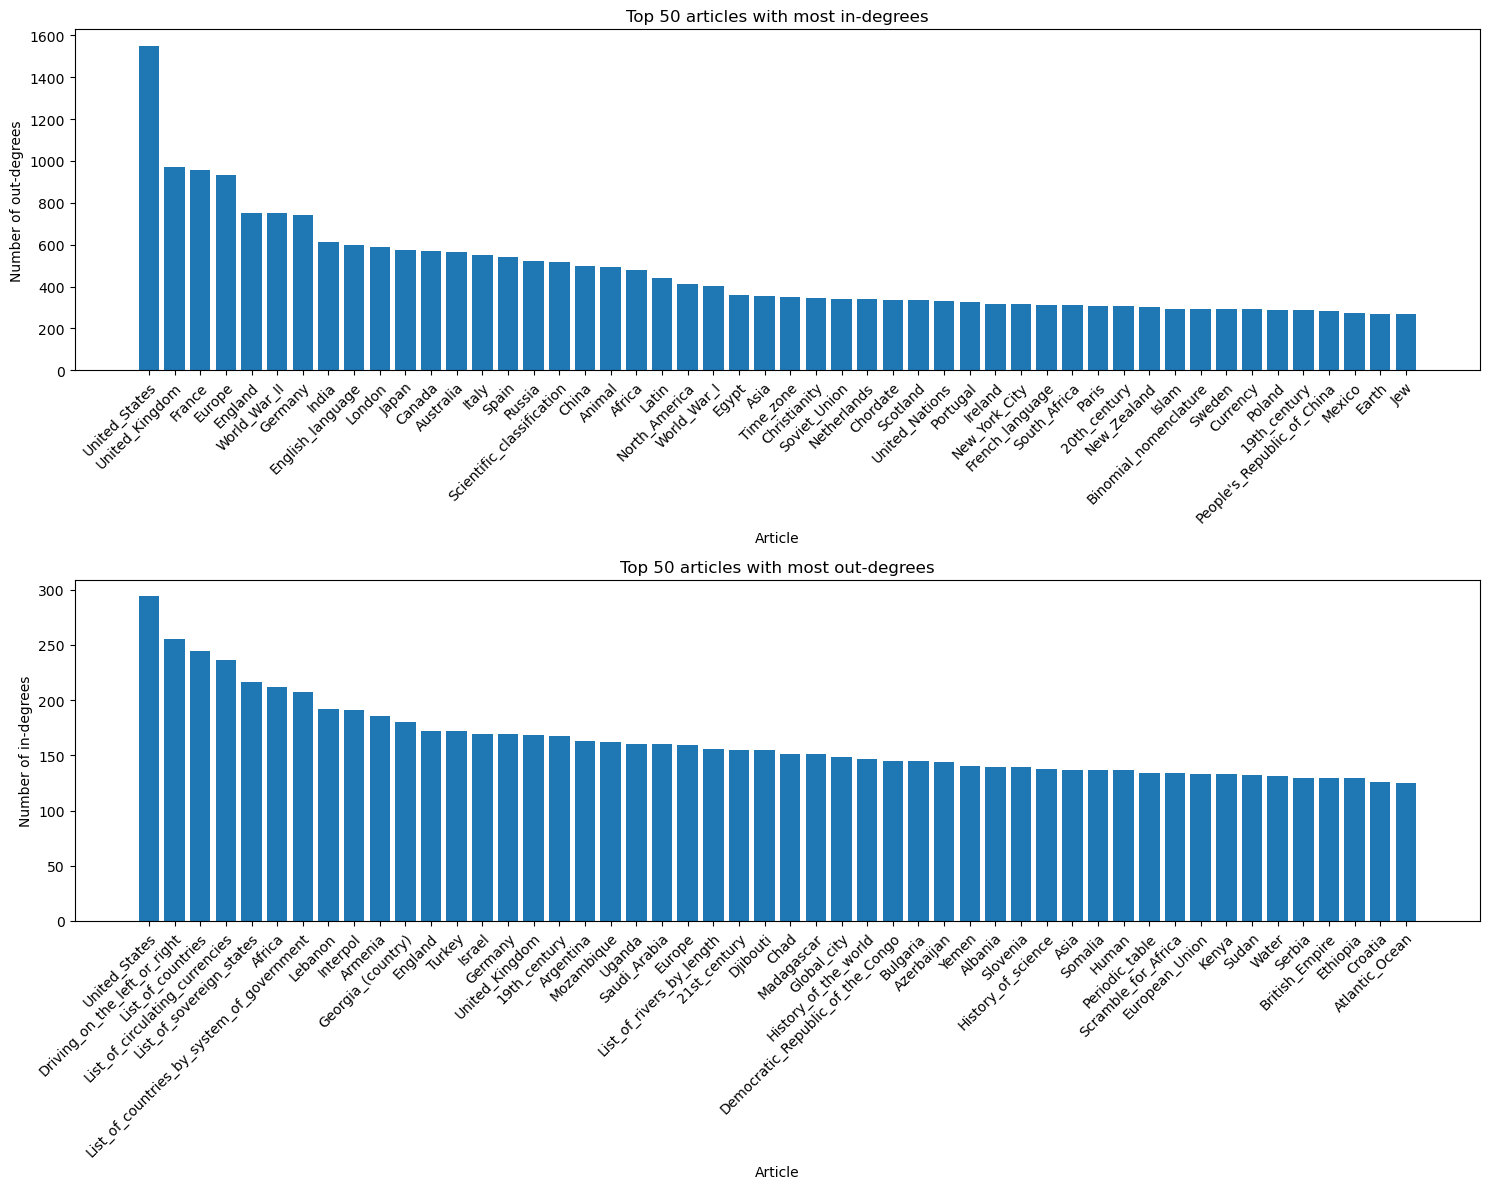

In [7]:
figs, axs = plt.subplots(2,1,figsize=(15,12))

k = 50

axs[0].bar(in_degrees[:k].index, in_degrees[:k]['in_degrees'])
axs[0].xaxis.set_ticks(in_degrees[:k].index)
axs[0].xaxis.set_ticklabels(in_degrees[:k].index, rotation=45, ha='right',rotation_mode="anchor")
axs[0].set_title(f"Top {k} articles with most in-degrees")
axs[0].set_xlabel("Article")
axs[0].set_ylabel("Number of out-degrees")


axs[1].bar(out_degrees[:k].index, out_degrees[:k]['out_degrees'])
axs[1].xaxis.set_ticks(out_degrees[:k].index)
axs[1].xaxis.set_ticklabels(out_degrees[:k].index, rotation=45, ha='right', rotation_mode="anchor")
axs[1].set_title(f"Top {k} articles with most out-degrees")
axs[1].set_xlabel("Article")
axs[1].set_ylabel("Number of in-degrees")

plt.tight_layout()

### Note on above plot

There are a lot of country related articles that have a high number of in- and out- degrees making them likely articles to be used in the game!!!

### Splitting the category information into category, sub-category and sub-sub-category

<AxesSubplot:>

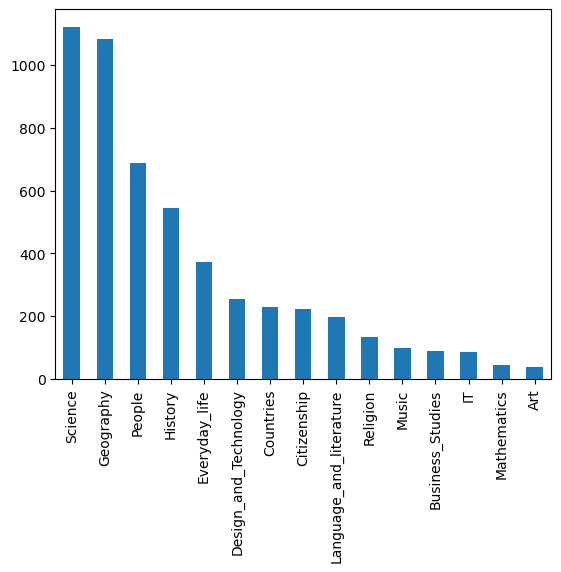

In [40]:
df_subcategories = df_categories.copy()
df_subcategories['category'].str.split('.', expand=True).shape
df_subcategories[['subject', 'category','subcategory','subsubcategory']] = df_subcategories['category'].str.split('.', expand=True)
df_subcategories.drop(columns=['subject'], inplace=True)

df_subcategories['category'].value_counts().plot.bar()

In [43]:
df_subcategories[df_subcategories['category'] == 'Countries']

,article,category,subcategory,subsubcategory
2,Åland,Countries,None,None
5,Éire,Countries,None,None
102,Abkhazia,Countries,None,None
109,Abu_Dhabi,Countries,None,None
141,Afghanistan,Countries,None,None
...,...,...,...,...
5022,West_Bank,Countries,None,None
5031,Western_Sahara,Countries,None,None
5159,Yemen,Countries,None,None
5182,Zambia,Countries,None,None


In [86]:
# Get list of articles with primary category as 'Countries'

df_countries = df_subcategories[df_subcategories['category'] == 'Countries']['article'].values

## Path analysis

In [13]:
df_finished_paths_only = df_finished_paths['path'].copy()
df_unfinished_paths_only = df_unfinished_paths['path'].copy()

In [18]:
# Separating all paths into individial articles from finished and unfinished paths
separated_finished_paths = df_finished_paths_only.str.split(";", expand=True)
separated_unfinished_paths = df_unfinished_paths_only.str.split(";", expand=True)

results = []
finished_targets = pd.DataFrame(['target'])
for idx in separated_finished_paths.index:
    first_none = separated_finished_paths.loc[idx].last_valid_index()
    finished_targets.loc[idx] = separated_finished_paths.loc[idx,first_none]
    results.append(';'.join(pair) for pair in zip(separated_finished_paths.loc[idx][:first_none], separated_finished_paths.loc[idx][1:first_none+1]))

played_links = pd.DataFrame(pd.DataFrame(results).values.flatten())
played_links = played_links[played_links.values != None]

df_finished_paths['startingArticle'] = separated_finished_paths.loc[:,0]
df_unfinished_paths['startingArticle'] = separated_unfinished_paths.loc[:,0]

target_articles = []
for idx in separated_finished_paths.index:
    first_none = separated_finished_paths.loc[idx].last_valid_index()
    target_articles.append(separated_finished_paths.loc[idx,first_none])

df_finished_paths['target'] = target_articles

In [87]:
# Get all finished paths with starting article in category 'Countries' as start and end

country_start_finished = df_finished_paths[df_finished_paths['startingArticle'].isin(df_countries)]
country_end_finished = df_finished_paths[df_finished_paths['target'].isin(df_countries)]

country_start_unfinished = df_unfinished_paths[df_unfinished_paths['startingArticle'].isin(df_countries)]
country_end_unfinished = df_unfinished_paths[df_unfinished_paths['target'].isin(df_countries)]

print(country_start_finished.shape)
print(country_end_finished.shape)
print(country_start_unfinished.shape)
print(country_end_unfinished.shape)

(2888, 7)
(4155, 7)
(1362, 7)
(590, 7)


In [102]:
countries_missing = []

for country in df_countries:
    country = country.replace('_',' ')
    if country not in df_UN_countries['Country or Area'].values:
        countries_missing.append(country)

replacement_country_names = [
    'Åland Islands', 'Ireland', 'Georgia', 'United Arab Emirates', 'Bolivia (Plurinational State of)',
    'Brunei Darussalam', 'Côte d’Ivoire', 'Cabo Verde', 'Czechia', 'United Arab Emirates',
    'Timor-Leste', 'Chile', 'Falkland Islands (Malvinas)', 'Micronesia (Federated States of)',
    'Ecuador', 'State of Palestine', 'Georgia', 'China, Hong Kong Special Administrative Region',
    'Iran (Islamic Republic of)', 'Republic of Korea', '', 'Lao People\'s Democratic Republic', 
    'Republic of Moldova', 'Netherlands (Kingdom of the)', 'Sint Maarten (Dutch part)', 
    'Democratic People\'s Republic of Korea', 'State of Palestine', 'China', 'China', 'Ireland',
    'North Macedonia', 'Russian Federation', 'Sao Tome and Principe', 'Serbia', 'Republic of Korea',
    "", 'Eswatini', 'Syrian Arab Republic', 'China', 'United Republic of Tanzania', 'Bahamas',
    'Gambia', 'China', 'Türkiye', 'Cyprus', 'United Kingdom of Great Britain and Northern Ireland',
    'United States of America', 'Holy See', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'State of Palestine'
]

replacement_countries = dict(zip(countries_missing, replacement_country_names))

print(replacement_countries)

{'Åland': 'Åland Islands', 'Éire': 'Ireland', 'Abkhazia': 'Georgia', 'Abu Dhabi': 'United Arab Emirates', 'Bolivia': 'Bolivia (Plurinational State of)', 'Brunei': 'Brunei Darussalam', "Côte d'Ivoire": 'Côte d’Ivoire', 'Cape Verde': 'Cabo Verde', 'Czech Republic': 'Czechia', 'Dubai': 'United Arab Emirates', 'East Timor': 'Timor-Leste', 'Easter Island': 'Chile', 'Falkland Islands': 'Falkland Islands (Malvinas)', 'Federated States of Micronesia': 'Micronesia (Federated States of)', 'Galápagos Islands': 'Ecuador', 'Gaza Strip': 'State of Palestine', 'Georgia (country)': 'Georgia', 'Hong Kong': 'China, Hong Kong Special Administrative Region', 'Iran': 'Iran (Islamic Republic of)', 'Korea': 'Republic of Korea', 'Kosovo': '', 'Laos': "Lao People's Democratic Republic", 'Moldova': 'Republic of Moldova', 'Netherlands': 'Netherlands (Kingdom of the)', 'Netherlands Antilles': 'Sint Maarten (Dutch part)', 'North Korea': "Democratic People's Republic of Korea", 'Palestinian territories': 'State of 

In [173]:
def get_region(country):
    country = country.replace('_',' ')
    if country in df_UN_countries['Country or Area'].values:
        region = df_UN_countries[df_UN_countries['Country or Area'] == country]['Region Name'].values
        # print(type(region))
        return region[0]
    else:
        new_country = replacement_countries[country]
        region = df_UN_countries[df_UN_countries['Country or Area'] == new_country]['Region Name'].values
        if len(region) > 0:
            return region[0]
        else:
            return ""

In [178]:
country_to_region = {}

for country in df_countries:
    country_to_region[country] = get_region(country)

# 'Kosovo' and 'South_Ossetia' are added manually as they are not present in the UN dataframe.
country_to_region['Kosovo'] = 'Europe'
country_to_region['South_Ossetia'] = 'Asia'

Text(0, 0.5, 'Count')

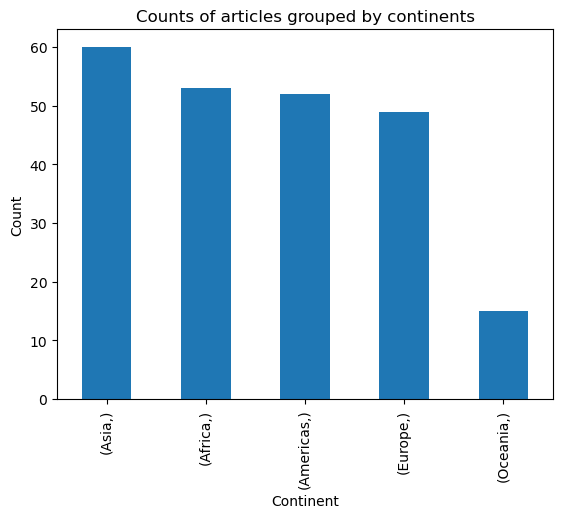

In [214]:
continents_count = pd.DataFrame(country_to_region.values()).value_counts()

continents_count.plot(kind='bar')
# plt.xticks(['Asia','Africa','Americas','Europe','Oceania'])

plt.title("Counts of articles grouped by continents")
plt.xlabel("Continent")
plt.ylabel("Count")

In [25]:
# Replacing the '_' character in articles with ' '

country_end_finished['target'].replace('_', ' ', regex=True, inplace=True)
country_start_finished['startingArticle'].replace('_', ' ', regex=True, inplace=True)
country_end_unfinished['target'].replace('_', ' ', regex=True, inplace=True)
country_start_unfinished['startingArticle'].replace('_', ' ', regex=True, inplace=True)

/var/folders/10/r0jczgpj3dg8j5bc90hs9p740000gn/T/ipykernel_66199/4217424198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_end_finished['target'].replace('_', ' ', regex=True, inplace=True)
/var/folders/10/r0jczgpj3dg8j5bc90hs9p740000gn/T/ipykernel_66199/4217424198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_start_finished['startingArticle'].replace('_', ' ', regex=True, inplace=True)
/var/folders/10/r0jczgpj3dg8j5bc90hs9p740000gn/T/ipykernel_66199/4217424198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [111]:
replacement_countries

with open('replacement_countries.pkl', 'wb') as f:
    pickle.dump(replacement_countries, f)

In [28]:
df_UN_countries_corrected = df_UN_countries.copy()

for idx, country in enumerate(df_UN_countries_corrected['Country or Area']):
    if country in replacement_countries.keys():
        df_UN_countries_corrected.loc[idx, 'Country or Area'] = replacement_countries[country]

In [30]:
country_end_region_finished = country_end_finished.merge(df_UN_countries_corrected[["Region Name", "Country or Area"]], left_on='target', right_on='Country or Area', how='left').copy()
end_grouped_by_area_finished = country_end_region_finished.groupby('Region Name').count()

country_start_region_finished = country_start_finished.merge(df_UN_countries_corrected[["Region Name", "Country or Area"]], left_on='startingArticle', right_on='Country or Area', how='left').copy()
start_grouped_by_area_finished = country_start_region_finished.groupby('Region Name').count()

country_end_region_unfinished = country_end_unfinished.merge(df_UN_countries_corrected[["Region Name", "Country or Area"]], left_on='target', right_on='Country or Area', how='left').copy()
end_grouped_by_area_unfinished = country_end_region_unfinished.groupby('Region Name').count()

country_start_region_unfinished = country_start_unfinished.merge(df_UN_countries_corrected[["Region Name", "Country or Area"]], left_on='startingArticle', right_on='Country or Area', how='left').copy()
start_grouped_by_area_unfinished = country_start_region_unfinished.groupby('Region Name').count()

In [31]:
country_start_region_finished[country_start_region_finished['Region Name'].isna()]['startingArticle'].unique()

array(['China', 'Gaza Strip', 'United Arab Emirates', 'Ireland',
       "People's Republic of China", 'Ecuador', 'Cyprus',
       'Republic of China', 'Kosovo', 'Serbia', 'Taiwan', 'Abkhazia',
       'Abu Dhabi', 'Chile', 'Korea', 'South Ossetia', 'West Bank'],
      dtype=object)

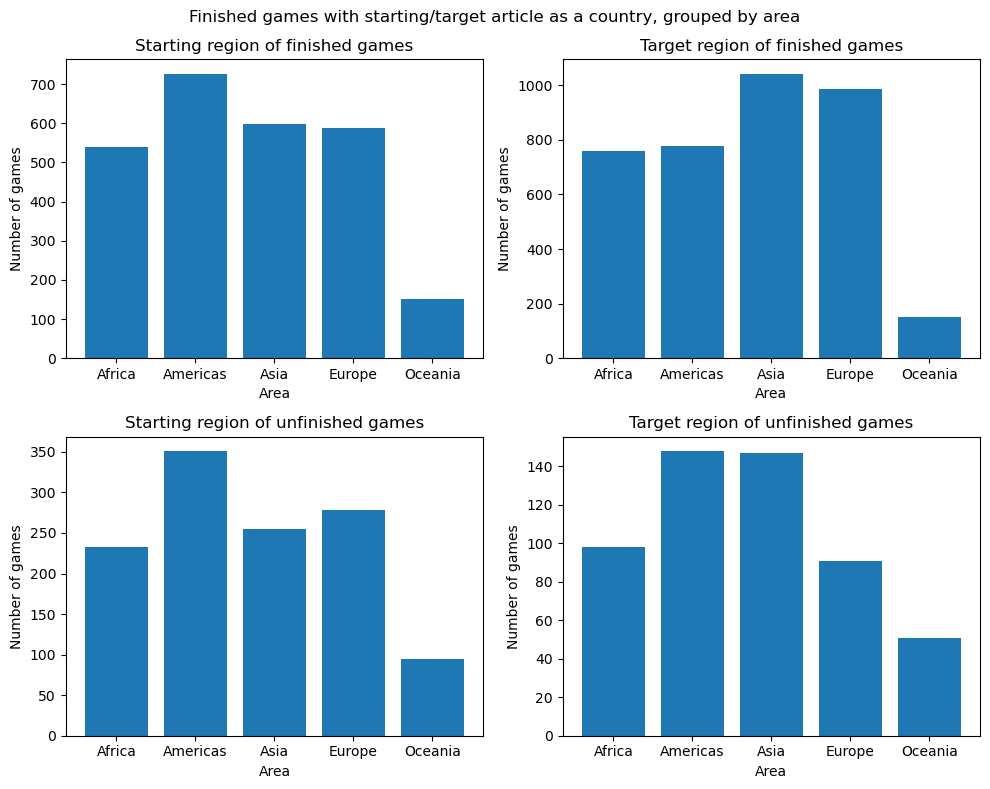

In [215]:
figs, axs = plt.subplots(2,2, figsize=(10,8))

figs.suptitle("Finished games with starting/target article as a country, grouped by area")

axs[0,0].bar(start_grouped_by_area_finished.index, start_grouped_by_area_finished['Country or Area'])
axs[0,0].set_title("Starting region of finished games")
axs[0,0].set_xlabel("Area")
axs[0,0].set_ylabel("Number of games")

axs[0,1].bar(end_grouped_by_area_finished.index, end_grouped_by_area_finished['Country or Area'])
axs[0,1].set_title("Target region of finished games")
axs[0,1].set_xlabel("Area")
axs[0,1].set_ylabel("Number of games")

axs[1,0].bar(start_grouped_by_area_unfinished.index, start_grouped_by_area_unfinished['Country or Area'])
axs[1,0].set_title("Starting region of unfinished games")
axs[1,0].set_xlabel("Area")
axs[1,0].set_ylabel("Number of games")

axs[1,1].bar(end_grouped_by_area_unfinished.index, end_grouped_by_area_unfinished['Country or Area'])
axs[1,1].set_title("Target region of unfinished games")
axs[1,1].set_xlabel("Area")
axs[1,1].set_ylabel("Number of games")

plt.tight_layout()

In [24]:
separated_played_links = played_links[0].str.split(";", expand=True)
separated_played_links.columns = ['from_article','to_article']
separated_played_links.reset_index(drop=True, inplace=True)

### Note that the below has duplicate rows due to some articles having more than one category

In [25]:
from_w_cat = pd.merge(separated_played_links, df_subcategories[['article', 'category']], left_on='from_article', right_on='article', how='left')
from_w_cat = from_w_cat.rename(columns={'category': 'from_category'})
from_w_cat.drop(['article'], axis=1, inplace=True)

both_w_cat = pd.merge(from_w_cat, df_subcategories[['article', 'category']], left_on='to_article', right_on='article', how='left')
both_w_cat = both_w_cat.rename(columns={'category': 'to_category'})
both_w_cat.drop(['article'], axis=1, inplace=True)
both_w_cat

,from_article,to_article,from_category,to_category
0,14th_century,15th_century,History,History
1,15th_century,16th_century,History,History
2,16th_century,Pacific_Ocean,History,Geography
3,Pacific_Ocean,Atlantic_Ocean,Geography,Geography
4,Atlantic_Ocean,Accra,Geography,Geography
...,...,...,...,...
450478,United_States,Abraham_Lincoln,Geography,People
450479,Ziad_Jarrah,Germany,People,Countries
450480,Ziad_Jarrah,Germany,People,Geography
450481,Germany,Jew,Countries,Geography


In [ ]:
# seperate each row and create a matrix with all the shortest distance

table_distance = np.array([[int(c) if c != '_' else -1 for c in row] for row in shortest_distance_text])


def seperate_path(path):

    # Split the path into individual articles
    articles = path.split(";")
    
    # Extract source and target
    source, target = articles[0], articles[-1]
    
    # Calculate the length, considering back-clicks
    length = len(articles) + articles.count('') - 1
    
    return source, target, length

# expand the finished paths
path_fin = paths_finished.copy()
path_fin = path_fin.assign(source=paths_finished['path'].apply(lambda x: seperate_path(x)[0]),
                           target=paths_finished['path'].apply(lambda x: seperate_path(x)[1]),
                           game_path=paths_finished['path'].apply(lambda x: seperate_path(x)[2]),
                           completed=True)

# expand the unfinished paths
path_ufin = paths_unfinished.copy()
path_ufin = path_ufin.assign(source=paths_unfinished['path'].apply(lambda x: seperate_path(x)[0]),
                             failure_article=paths_unfinished['path'].apply(lambda x: seperate_path(x)[1]),
                             game_path=paths_unfinished['path'].apply(lambda x: seperate_path(x)[2]),
                             completed=False,
                             target=paths_unfinished["target"])

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)[["source", "target",  "hashedIpAddress", "timestamp",
                                                                     "durationInSec", "game_path",
                                                                     "completed", "rating","type"]]
                                                                       

# Find the index of an article in the helper DataFrame
def find_article_index(article, helper_df):
    try:
        return helper_df.loc[article]
    except KeyError:
        return None

# Calculate the shortest distance between source and target indices
def calculate_shortest_distance(source_idx, target_idx):
    try:
        return table_distance[source_idx, target_idx][0]
    except KeyError:
        return None

# Finding the shortest path length between a source and a target
def find_path_distance(source, target, helper_df):
    source_idx = find_article_index(source, helper_df)
    target_idx = find_article_index(target, helper_df)

    if source_idx is not None and target_idx is not None:
        return calculate_shortest_distance(source_idx, target_idx)
    else:
        # Handle the case where source or target is not present in the index
        return None  # You can customize this behavior based on your specific needs


articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
# Create a copy of the 'path_overview' DataFrame to avoid modifying the original
path_overview_copy = path_overview.copy()

# Apply the find_path_distance function to each row
path_overview_copy['shortest_distance'] = path_overview_copy.apply(
    lambda row: find_path_distance(row['source'], row['target'], help_articles), axis=1
)

# Update the original 'path_overview' DataFrame with the new 'shortest_distance' column
path_overview['shortest_distance'] = path_overview_copy['shortest_distance']

#remove all rows where the source or target article is not among the available articles in the dataset
path_overview = path_overview.drop(path_overview[~(path_overview['source'].isin(articles['article'].array))].index)
path_overview = path_overview.drop(path_overview[~(path_overview['target'].isin(articles['article'].array))].index)

# remove all rows where there is no path between the source article and target article
path_overview = path_overview.drop(path_overview[path_overview['shortest_distance'] == -1].index) 
path_overview.insert(4, 'shortest_distance', path_overview.pop('shortest_distance'))
path_overview# seperate each row and create a matrix with all the shortest distance

table_distance = np.array([[int(c) if c != '_' else -1 for c in row] for row in shortest_distance_text])


def seperate_path(path):

    # Split the path into individual articles
    articles = path.split(";")
    
    # Extract source and target
    source, target = articles[0], articles[-1]
    
    # Calculate the length, considering back-clicks
    length = len(articles) + articles.count('') - 1
    
    return source, target, length

# expand the finished paths
path_fin = paths_finished.copy()
path_fin = path_fin.assign(source=paths_finished['path'].apply(lambda x: seperate_path(x)[0]),
                           target=paths_finished['path'].apply(lambda x: seperate_path(x)[1]),
                           game_path=paths_finished['path'].apply(lambda x: seperate_path(x)[2]),
                           completed=True)

# expand the unfinished paths
path_ufin = paths_unfinished.copy()
path_ufin = path_ufin.assign(source=paths_unfinished['path'].apply(lambda x: seperate_path(x)[0]),
                             failure_article=paths_unfinished['path'].apply(lambda x: seperate_path(x)[1]),
                             game_path=paths_unfinished['path'].apply(lambda x: seperate_path(x)[2]),
                             completed=False,
                             target=paths_unfinished["target"])

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)[["source", "target",  "hashedIpAddress", "timestamp",
                                                                     "durationInSec", "game_path",
                                                                     "completed", "rating","type"]]
                                                                       

# Find the index of an article in the helper DataFrame
def find_article_index(article, helper_df):
    try:
        return helper_df.loc[article]
    except KeyError:
        return None

# Calculate the shortest distance between source and target indices
def calculate_shortest_distance(source_idx, target_idx):
    try:
        return table_distance[source_idx, target_idx][0]
    except KeyError:
        return None

# Finding the shortest path length between a source and a target
def find_path_distance(source, target, helper_df):
    source_idx = find_article_index(source, helper_df)
    target_idx = find_article_index(target, helper_df)

    if source_idx is not None and target_idx is not None:
        return calculate_shortest_distance(source_idx, target_idx)
    else:
        # Handle the case where source or target is not present in the index
        return None  # You can customize this behavior based on your specific needs


articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
# Create a copy of the 'path_overview' DataFrame to avoid modifying the original
path_overview_copy = path_overview.copy()

# Apply the find_path_distance function to each row
path_overview_copy['shortest_distance'] = path_overview_copy.apply(
    lambda row: find_path_distance(row['source'], row['target'], help_articles), axis=1
)

# Update the original 'path_overview' DataFrame with the new 'shortest_distance' column
path_overview['shortest_distance'] = path_overview_copy['shortest_distance']

#remove all rows where the source or target article is not among the available articles in the dataset
path_overview = path_overview.drop(path_overview[~(path_overview['source'].isin(articles['article'].array))].index)
path_overview = path_overview.drop(path_overview[~(path_overview['target'].isin(articles['article'].array))].index)

# remove all rows where there is no path between the source article and target article
path_overview = path_overview.drop(path_overview[path_overview['shortest_distance'] == -1].index) 
path_overview.insert(4, 'shortest_distance', path_overview.pop('shortest_distance'))
path_overview